# Linear Regression On Car Data Set 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%matplotlib inline 

#ml lib
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import ElasticNet, ElasticNetCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,accuracy_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

import seaborn as sns
sns.set()


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

!pip install category_encoders

In [ ]:
#read the CSV data

data = pd.read_csv('/content/gdrive/My Drive/Google Collab Files/DataSets/Car_details.csv')

#data = pd.read_csv('/kaggle/input/car-details/Car_details.csv')



#Exploratory data analysis

In [ ]:
#reading the first 5 record
data.head() 

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [ ]:
#checking dimensions of dataset 8128 rows and 13 columns 
data.shape

(8128, 13)

In [ ]:
#printing summary of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [ ]:
#there are null items
data.isna().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [ ]:
#Lets fill the null by Zero
data.fillna(0, inplace = True) #inplace = true reflect the changes in tthe orginal dataset

In [ ]:
#Lets try to fill the null value with mean or median for each columns 

#Here mileage, engine, max_power, torque and seats will vary as per the car type so we have to find the mean, median by 
#car type to fill those values.

#First lets remove the strings appended to the numerical values from the columns: mileage, engine, max_power 

data.mileage = data.mileage.apply(lambda x: float(str(x).split()[0]))

data.engine = data.engine.apply(lambda x: int(str(x).split()[0]))

data.max_power = data.max_power.apply(lambda x: str(x).split()[0])

data.query('max_power.str.contains("b")', engine='python')

#the above row is creating problem  in converting our column data type lets resolve this now

data.iloc[4933,10] = 0 #assign zero 

data.iloc[4933,10]  # cross check 

data.max_power = data.max_power.apply(lambda x: float(x)) #now we were able to change the data type of max power

data.torque = data.torque.astype(str)

data.torque = data.torque.str.extract('(^\d*)')

data.torque = data.torque.astype(int)

data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11,5.0


In [ ]:
#Lets fill zero values with that of mean

data['car_name'] = data.name.str.split().str[:2].str.join(' ')

mileage_mean = data[(data.mileage != 0) & (data.max_power != 0) &  (data.max_power != 0) &
                    (data.torque != 0) & (data.seats != 0)].groupby(['car_name']).mean()

count = 0;
for i in mileage_mean.index:
    mileage = data[(data.car_name == i) & (data.mileage == 0.0)].copy()
    engine = data[(data.car_name == i) & (data.engine == 0)].copy()
    max_power = data[(data.car_name == i) & (data.max_power == 0)].copy()
    torque = data[(data.car_name == i) & (data.torque == 0)].copy()
    seats = data[(data.car_name == i) & (data.seats == 0)].copy()
    if not mileage.empty:
        mileage.loc[:, 'mileage'] = mileage_mean.loc[i, 'mileage']    
        data.update(mileage)
    if not engine.empty:
        engine.loc[:, 'engine'] = mileage_mean.loc[i, 'engine'] 
        data.update(engine)
    if not max_power.empty:
        max_power.loc[:, 'max_power'] = mileage_mean.loc[i, 'max_power'] 
        data.update(max_power)
    if not torque.empty:
        torque.loc[:, 'torque'] = mileage_mean.loc[i, 'torque']  
        data.update(torque)
    if not seats.empty:
        seats.loc[:, 'seats'] = mileage_mean.loc[i, 'seats']
        data.update(seats)
    count+=1
else:
    print("updated 199 columns")
    print(count)
    print("end")        

    


updated 199 columns
199
end


In [ ]:
#Lets drop all other left zero rows

#Left zero rows
Zero_values = data[(data.mileage == 0) & (data.max_power == 0) &  (data.max_power == 0) &
                    (data.torque == 0) & (data.seats == 0)]

data.drop(Zero_values.index, inplace=True)

#cross check again, it should not display empty 
data[(data.mileage == 0) & (data.max_power == 0) &  (data.max_power == 0) &
                    (data.torque == 0) & (data.seats == 0)]

#Lets drop the car_name clumn that we generated to find the mean in order to fill the empty fields. 
data.drop(columns= 'car_name', inplace=True)

data.head()



,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014.0,450000.0,145500.0,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190.0,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014.0,370000.0,120000.0,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250.0,5.0
2,Honda City 2017-2020 EXi,2006.0,158000.0,140000.0,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,12.0,5.0
3,Hyundai i20 Sportz Diesel,2010.0,225000.0,127000.0,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.0,5.0
4,Maruti Swift VXI BSIII,2007.0,130000.0,120000.0,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,11.0,5.0


In [ ]:
#print("\n----------- Minimum -----------\n")
#print(data[data.columns].min())
 
#print("\n----------- Maximum -----------\n")
#print(data[data.columns].max())

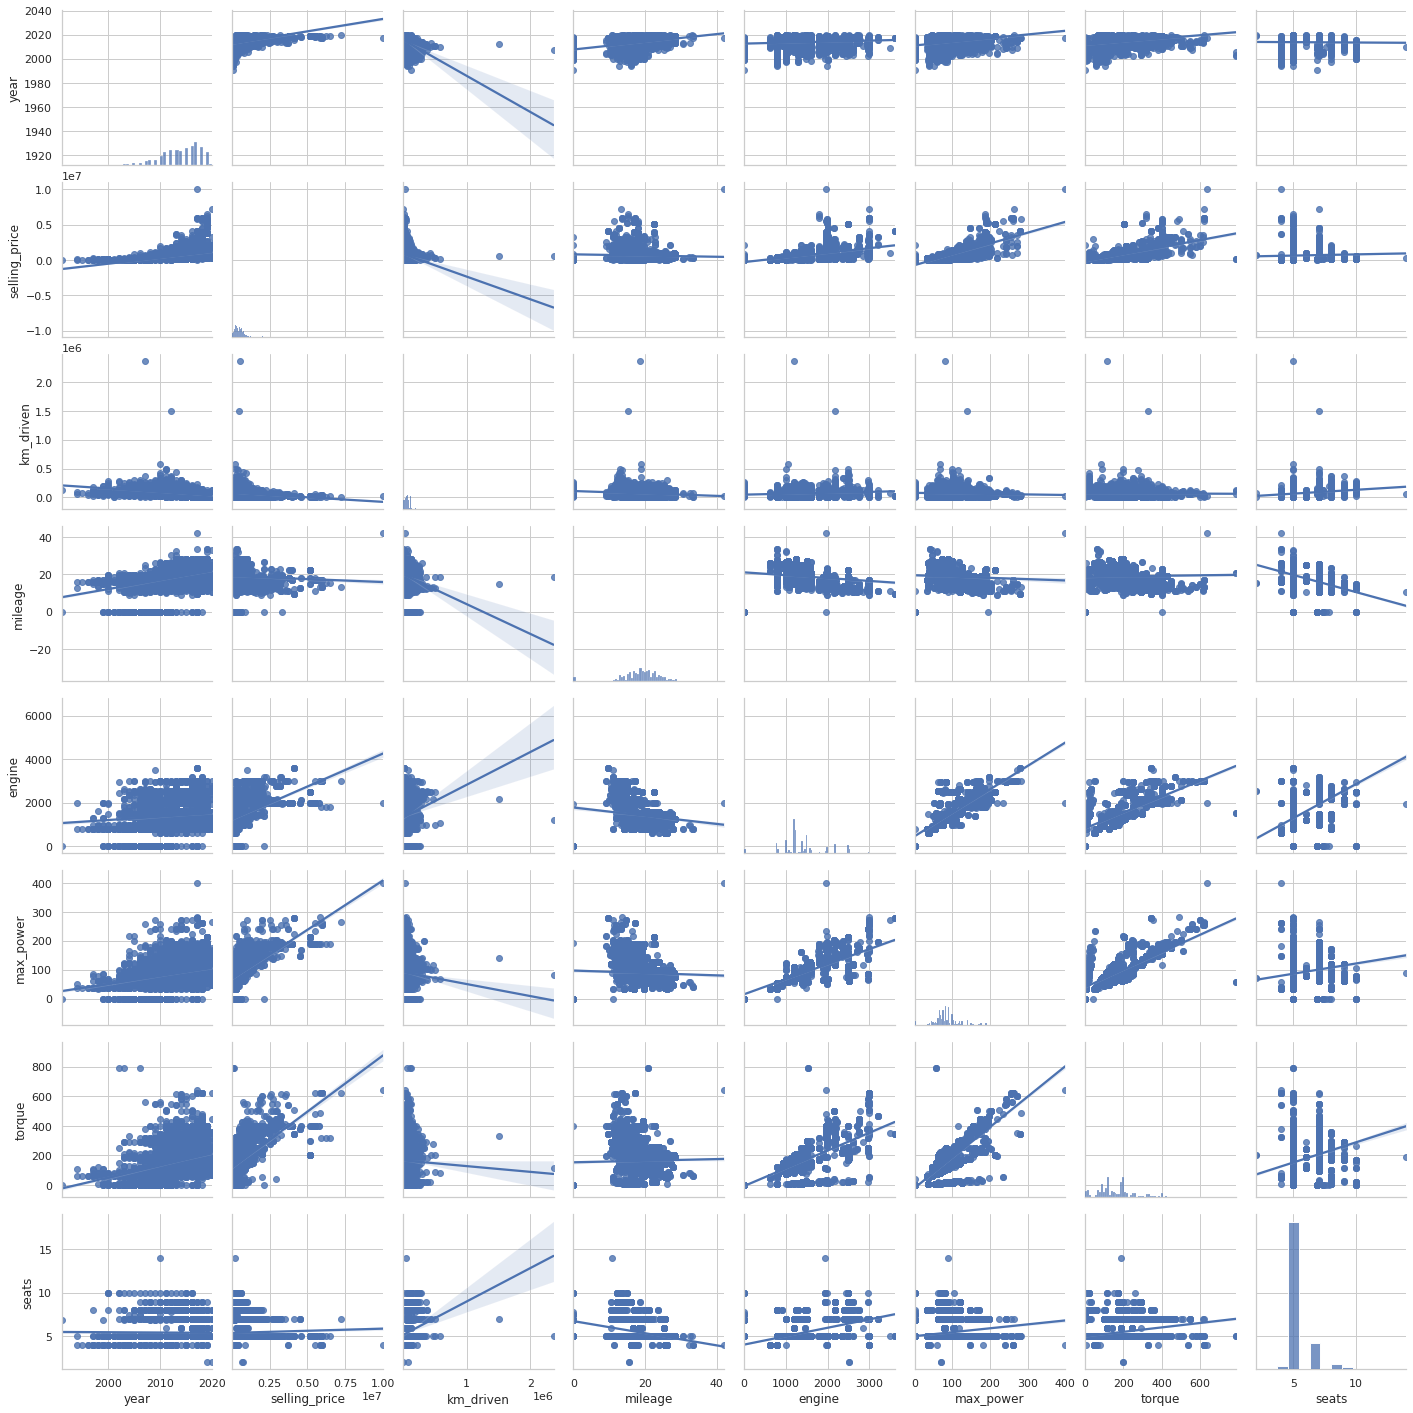

In [ ]:
#Lets visualise the graph

sns.set_style('whitegrid')

sns.pairplot(data, kind='reg')

#most of the points clutted around the regression line, so the use of Linear reg on this data set should yield expected results

In [ ]:
y = data['selling_price']
X = data.drop(columns= ['selling_price'])
X.columns
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8107 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          8107 non-null   object 
 1   year          8107 non-null   float64
 2   km_driven     8107 non-null   float64
 3   fuel          8107 non-null   object 
 4   seller_type   8107 non-null   object 
 5   transmission  8107 non-null   object 
 6   owner         8107 non-null   object 
 7   mileage       8107 non-null   float64
 8   engine        8107 non-null   float64
 9   max_power     8107 non-null   float64
 10  torque        8107 non-null   float64
 11  seats         8107 non-null   float64
dtypes: float64(7), object(5)
memory usage: 823.4+ KB


In [ ]:
#Lets perform Encoding on categorical columns
# All the above columns influences the selling price of a car, so lets use target encoding 
#https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/
#https://www.youtube.com/watch?v=irHhDMbw3xo&list=PL5-da3qGB5ICeMbQuqbbCOQWcS6OYBr5A&t=184s
import category_encoders as ce
import xgboost;
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRFRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.compose import make_column_selector
import numpy as np
import time

column_trans = make_column_transformer(
       (StandardScaler(),
        make_column_selector(dtype_include=np.float64)),  
       (ce.TargetEncoder(),
        make_column_selector(dtype_include=object)))  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


pipeline = Pipeline([ 
        ('col_transformer', column_trans),
        ('clf', GradientBoostingRegressor(alpha=0.47000000000000003, ccp_alpha=0.0,
                          criterion='mse', init=None, learning_rate=0.36,
                          loss='ls', max_depth=3, max_features='auto',
                          max_leaf_nodes=60, min_impurity_decrease=0.0,
                          min_impurity_split=None, min_samples_leaf=8,
                          min_samples_split=10, min_weight_fraction_leaf=0.0,
                          n_estimators=1100, n_iter_no_change=None,
                          presort='deprecated', random_state=None,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False))
])



pipeline.fit(X_train, y_train)
print("test score is",pipeline.score(X_test, y_test))
print("train score is", pipeline.score(X_train, y_train))

#sorted(pipeline.get_params().keys())

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


test score is 0.9712539632784076
train score is 0.9969705458634863


In [ ]:
#pipeline.score(X_train, y_train)

#column_trans.fit_transform(X, y)

#column_trans

#data.to_csv("transformed_data.csv")
pipeline.score(X, y)

0.9889298189595755

Adj r2 on train 0.9969641241271079
Adj r2 on test 0.9711114209475568
MAE 67051.84454276791
MSE 19491099955.03818
RMAE 139610.52952781957


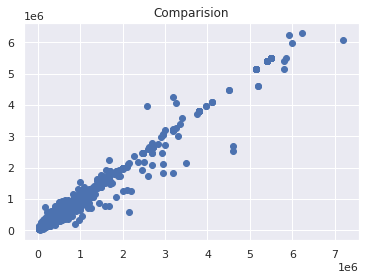

In [ ]:
#Evaluation
#https://scikit-learn.org/stable/modules/model_evaluation.html

# Let's create a function to create adjusted R-Squared
def adj_r2(X,y):
    r2 = pipeline.score(X, y)
    n = X.shape[0]
    p = X.shape[1]
    adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
    return adjusted_r2

print("Adj r2 on train", adj_r2(X_train,y_train))
print("Adj r2 on test", adj_r2(X_test,y_test))

y_predict = pipeline.predict(X_test)
plt.scatter(y_test,y_predict)
plt.title('Comparision')
#plt.savefig('car_price_scater.png')

print("MAE", mean_absolute_error(y_test,y_predict))
print("MSE", mean_squared_error(y_test,y_predict))
print("RMAE", np.sqrt(mean_squared_error(y_test,y_predict)))

#Mean Absolute Error (MAE): This measures the absolute average distance between the real data and the predicted data, but it fails to punish large errors in prediction.
#Mean Square Error (MSE): This measures the squared average distance between the real data and the predicted data. Here, larger errors are well noted (better than MAE). But the disadvantage is that it also squares up the units of data as well. So, evaluation with different units is not at all justified.
#Root Mean Squared Error (RMSE): This is actually the square root of MSE. Also, this metrics solves the problem of squaring the units.




In [ ]:
#test = pd.DataFrame([['Toyota Innova Crysta 2.5 VX BS IV', 2011.0, 60000.0, 'Diesel', 'Individual', 'Manual',
                            'First Owner', 12.8, 2494.0, 102.0, 20.0, 7.0]],
                          columns=['name', 'year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner',
                                   'mileage',
                                   'engine', 'max_power', 'torque', 'seats'], dtype=object)
#predictions = pipeline.predict(test)

#predictions

array([711962.55822382])

## Randomized Search CV

Lets use the below models and see which one performs well.

* linear regression
* ridge regression
* lasso regression
* elastic net
* decision tree
* random forest
* ada boost
* gradient boost
* xg boost



In [ ]:
!pip install xgboost

In [ ]:


param_grid = [
        {   
          "clf": [Ridge()],
          "clf__alpha": np.arange(0, 1, 0.01),
        },
        {
          "clf": [Lasso()],
          "clf__alpha": np.arange(0, 1, 0.01),
        },
        {
          "clf": [ElasticNet()],
          "clf__alpha": np.arange(0, 1, 0.01)            
        },
        { 

          "clf": [XGBRFRegressor()],         
          "clf__n_estimators": [400, 700, 1000],
          "clf__colsample_bytree": [0.7, 0.8],
          "clf__max_depth": [15,20,25],
          "clf__reg_alpha": [1.1, 1.2, 1.3],
          "clf__reg_lambda": [1.1, 1.2, 1.3],
          "clf__subsample": [0.7, 0.8, 0.9]
        } , 
        {
          "clf": [DecisionTreeRegressor()],
          "clf__criterion": ["mse", "friedman_mse", "mae"],
          "clf__splitter": ["best", "random"],
          "clf__max_depth": [1, 3, 5, 7, 9, 10, 11, 12, 14, 15, 18, 20, 25, 28, 30, 33, 38, 40],
          "clf__min_samples_split": [2, 4, 6, 8, 10, 15, 20],
          "clf__min_samples_leaf": [i for i in range(1, 11)],
          "clf__max_leaf_nodes": [None] + [i for i in range(10, 91, 10)],
          "clf__max_features": ["auto", "log2", "sqrt", None]            
        },
        {
            "clf": [RandomForestRegressor()],
            "clf__n_estimators": np.linspace(100, 1200, 12).astype(int),
            "clf__criterion": ["mse", "friedman_mse", "mae"],
            "clf__max_depth": [1, 3, 5, 7, 9, 10, 11, 12, 14, 15, 18, 20, 25, 28, 30, 33, 38, 40],
            "clf__min_samples_split": [2, 4, 6, 8, 10, 15, 20],
            "clf__min_samples_leaf": [i for i in range(1, 11)],
            "clf__max_leaf_nodes": [None] + [i for i in range(10, 91, 10)],
            "clf__max_features": ["auto", "log2", "sqrt", None]
        },
        {
            "clf": [AdaBoostRegressor()],
            "clf__n_estimators": np.linspace(100, 1200, 12).astype(int),
            "clf__learning_rate": np.arange(0, 1, 0.01),
            "clf__loss": ['linear', 'square', 'exponential']            
        },
        {
            "clf": [GradientBoostingRegressor()],
            "clf__learning_rate": np.arange(0, 1, 0.01),
            "clf__n_estimators": np.linspace(100, 1200, 12).astype(int),
            "clf__criterion": ['friedman_mse', 'mse', 'mae'],
            "clf__min_samples_split": [2, 4, 6, 8, 10, 15, 20],
            "clf__min_samples_leaf": [i for i in range(1, 11)],
            "clf__max_depth": [1, 3, 5, 7, 9, 10, 11, 12, 14, 15, 18, 20, 25, 28, 30, 33, 38, 40],
            "clf__max_features": ["auto", "log2", "sqrt", None],
            "clf__max_leaf_nodes": [None] + [i for i in range(10, 91, 10)],
            "clf__alpha": np.arange(0, 1, 0.01)    
        }
        ]

param_grid





In [ ]:
#Lets apply grid search cv and find the optimised one 
start_time = time.time()
best_model = {}
best_model_info = []

grid_search = RandomizedSearchCV(pipeline, param_grid , cv=10, verbose=1,n_jobs=-1, random_state=4)
grid_search.fit(X_train, y_train)

print(f"Best params:")
print(grid_search.best_params_)
print("Best score in grid search:")
print(grid_search.best_score_)
print("best test score for chosen  model from grid search:")
print(grid_search.score(X_test, y_test))

In [ ]:
#Now we found ' GradiantBoosting Regressor as the best model, Let's use this as a final model and persist then model. 

with open("car_model.pickle", "wb") as f:
    pickle.dump(pipeline, f)